# CEE609 Research Project: Model Train and Validate Code

Andrea Hoe and Melissa Yeung

Due 11/24/2024

# Import libraries

In [1]:
%%capture
from PIL import Image
from google.colab import drive
from scipy.interpolate import griddata
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

drive.mount('/content/drive')

## Rebuild grid

In [2]:
GBR_loc  = np.array([[1250,2050], [7550,8250]])
GBR_sz   = np.array([GBR_loc[0,1]-GBR_loc[0,0],GBR_loc[1,1]-GBR_loc[1,0]])
xv       = np.arange(0, GBR_sz[1])
yv       = np.arange(0, GBR_sz[0])

XG, YG = np.meshgrid(xv, yv)
XGv = XG.reshape(-1, 1)
YGv = YG.reshape(-1, 1)

# Inspect training dataset

## Load in data

In [3]:
path = 'drive/MyDrive/Fall 2024/CEE609/'

WLA18 = np.load(path+"WLA18.npy")
PAR18 = np.load(path+"PAR18.npy")
PIC18 = np.load(path+"PIC18.npy")
POC18 = np.load(path+"POC18.npy")
CHL19 = np.load(path+"CHL19.npy")

## Look at scatterplots

In [4]:
WLA18_v = WLA18[:,0]
PAR18_v = PAR18[:,0]
PIC18_v = PIC18[:,0]
POC18_v = POC18[:,0]
CHL19_v = CHL19[:,0]

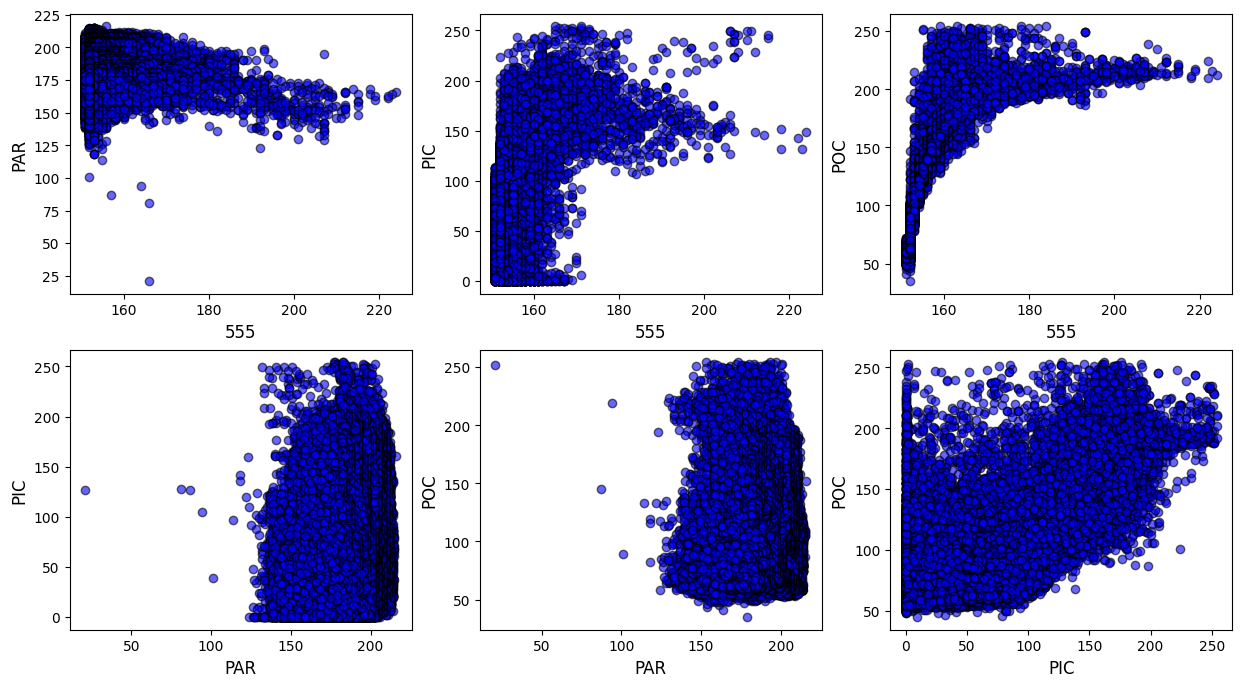

In [5]:
# between predictor variables

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

axes[0, 0].scatter(WLA18_v, PAR18_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 0].set_xlabel("555", fontsize=12);
axes[0, 0].set_ylabel("PAR", fontsize=12);

axes[0, 1].scatter(WLA18_v, PIC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 1].set_xlabel("555", fontsize=12);
axes[0, 1].set_ylabel("PIC", fontsize=12);

axes[0, 2].scatter(WLA18_v, POC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 2].set_xlabel("555", fontsize=12);
axes[0, 2].set_ylabel("POC", fontsize=12);

axes[1, 0].scatter(PAR18_v, PIC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 0].set_xlabel("PAR", fontsize=12);
axes[1, 0].set_ylabel("PIC", fontsize=12);

axes[1, 1].scatter(PAR18_v, POC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 1].set_xlabel("PAR", fontsize=12);
axes[1, 1].set_ylabel("POC", fontsize=12);

axes[1, 2].scatter(PIC18_v, POC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 2].set_xlabel("PIC", fontsize=12);
axes[1, 2].set_ylabel("POC", fontsize=12);


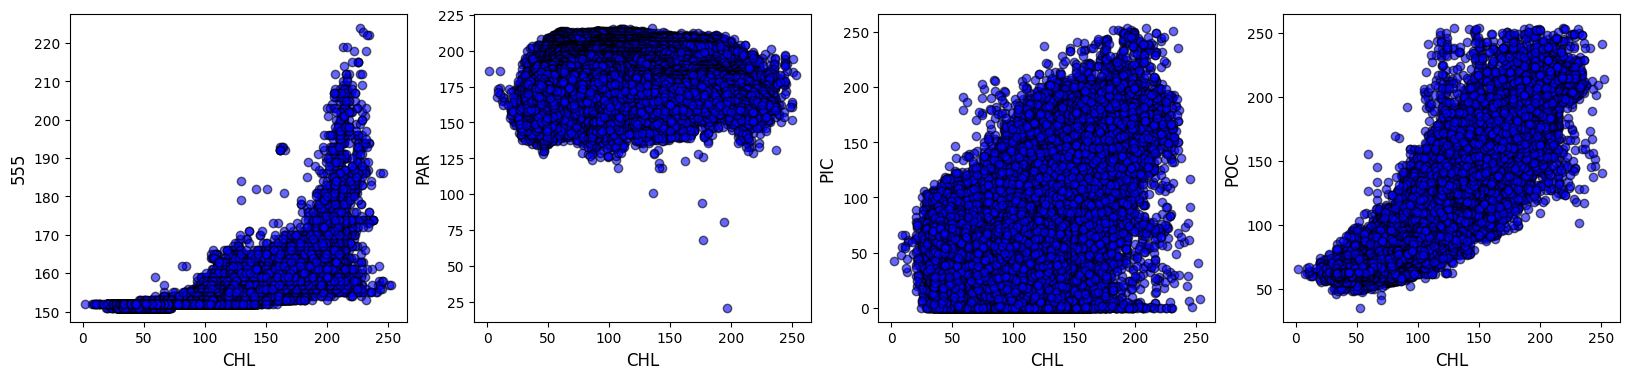

In [6]:
# between variables and predictand

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

axes[0].scatter(CHL19_v, WLA18_v, color='blue', alpha=0.6, edgecolors='k');
axes[0].set_xlabel("CHL", fontsize=12);
axes[0].set_ylabel("555", fontsize=12);

axes[1].scatter(CHL19_v, PAR18_v, color='blue', alpha=0.6, edgecolors='k');
axes[1].set_xlabel("CHL", fontsize=12);
axes[1].set_ylabel("PAR", fontsize=12);

axes[2].scatter(CHL19_v, PIC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[2].set_xlabel("CHL", fontsize=12);
axes[2].set_ylabel("PIC", fontsize=12);

axes[3].scatter(CHL19_v, POC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[3].set_xlabel("CHL", fontsize=12);
axes[3].set_ylabel("POC", fontsize=12);


# Train the model

## Prepare the data

In [7]:
# remove rows containing NaN
data_all = np.hstack([WLA18, PAR18, PIC18, POC18, CHL19])
mask = ~np.isnan(data_all).any(axis=1)


# assign variables
X_train = np.hstack([WLA18, PAR18, PIC18, POC18])
Y_train = CHL19

X_train = X_train[mask]
Y_train = Y_train[mask]


# ensure there are no NaN values
print("NaN values in X_train: ", np.isnan(X_train).any())
print("NaN values in Y_train: ", np.isnan(Y_train).any())

# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


print("\nShape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)


NaN values in X_train:  False
NaN values in Y_train:  False

Shape of X_train:  (186336, 144)
Shape of Y_train:  (186336, 1)


## Train
* Search for best parameter

In [8]:
parameters  = {'alpha': [1270, 1280, 1290, 1300, 1310, 1320, 1330]} # has been tested multiple times and narrowed down
ridge       = Ridge()
grid_search = GridSearchCV(ridge, parameters, cv=5)
grid_search.fit(X_train, Y_train)


best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)


model        = grid_search.best_estimator_
Y_train_pred = model.predict(X_train)
Y_test_pred  = model.predict(X_test)


coefficients = model.coef_
print("Model Coefficients:", coefficients)

Best alpha: 1310
Model Coefficients: [[ 6.28930565e-02 -3.63450428e-01 -1.02459824e+00 -3.72340235e-01
   7.76493577e-02  6.23378715e-01 -9.95128810e-01 -5.04471112e-02
  -2.33551909e-01 -3.75431648e-01  3.59233608e-01  1.12865217e-01
   3.07795622e-01  5.44899925e-01  8.01189854e-01  2.03269560e-01
   4.82939994e-02 -1.86872990e-02 -6.16094089e-01 -1.02813890e-01
   9.88597608e-02  7.57477644e-02 -3.73256240e-02  8.78843513e-01
   3.15755679e-01 -5.06476552e-01 -1.77424665e-01 -1.21916235e+00
  -3.48243684e-01  4.69472297e-01 -4.09916963e-01  4.76276127e-03
   1.99437921e-01  2.53492429e-01  1.77095561e-02  2.37948282e-01
  -1.46705089e-02  3.22894033e-02 -3.73576151e-02  5.21449962e-03
  -6.48017664e-02  2.54855504e-02  1.06505281e-01 -3.13939950e-02
   5.91445749e-02  1.67064618e-02  6.32546167e-02 -1.20381817e-02
   1.83767171e-02  6.10720161e-02 -4.42070430e-02  5.37364896e-02
  -3.25946517e-03  8.54017978e-03 -5.58954880e-02  2.43293616e-03
  -5.93070853e-02 -2.74524651e-02 -4.66

## Model Evaluation


In [9]:
print("Training Set Performance:")
print("> MSE:", mean_squared_error(Y_train, Y_train_pred))
print("> R^2 Score:", r2_score(Y_train, Y_train_pred))

err_train = abs( (Y_train_pred - Y_train) / Y_train )
print("> Mean Error: " + str(np.mean(err_train)*100) + "%")



print("\nTest Set Performance:")
print("> MSE:", mean_squared_error(Y_test, Y_test_pred))
print("> R^2 Score:", r2_score(Y_test, Y_test_pred))

err_test = abs( (Y_test_pred - Y_test) / Y_test )
print("> Mean Error: " + str(np.mean(err_test)*100) + "%")


Training Set Performance:
> MSE: 51.00522938698819
> R^2 Score: 0.9275201985547802
> Mean Error: 6.496554487342543%

Test Set Performance:
> MSE: 52.66574115385253
> R^2 Score: 0.9259565000779351
> Mean Error: 6.586929961495904%


## Compare through plots

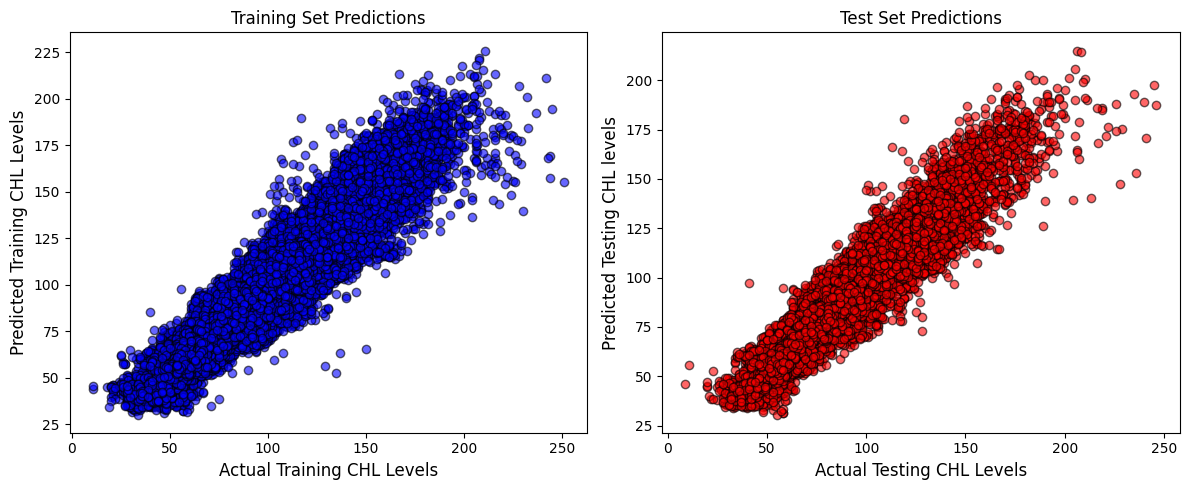

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(Y_train, Y_train_pred, color='blue', alpha=0.6, edgecolors='k')
axes[0].set_xlabel("Actual Training CHL Levels", fontsize=12)
axes[0].set_ylabel("Predicted Training CHL Levels", fontsize=12)
axes[0].set_title("Training Set Predictions")

axes[1].scatter(Y_test, Y_test_pred, color='red', alpha=0.6, edgecolors='k')
axes[1].set_xlabel("Actual Testing CHL Levels", fontsize=12)
axes[1].set_ylabel("Predicted Testing CHL levels", fontsize=12)
axes[1].set_title("Test Set Predictions")


plt.tight_layout()
plt.show()

## Test using full training dataset

In [11]:
# remove rows containing NaN
X_test = np.hstack([WLA18, PAR18, PIC18, POC18])
mask = ~np.isnan(X_test).any(axis=1)

X_test = X_test[mask]
xgv    = XGv[mask]
ygv    = YGv[mask]

# ensure there are no NaN values
print("NaN values in X_test: ", np.isnan(X_test).any())


print("Shape of X_test: ", X_test.shape)
print("Shape of xgv   : ", xgv.shape)
print("Shape of ygv.  : ", ygv.shape)

NaN values in X_test:  False
Shape of X_test:  (234824, 144)
Shape of xgv   :  (234824, 1)
Shape of ygv.  :  (234824, 1)


In [12]:
Y_test = model.predict(X_test)

### Reinterpolate onto grid and plot

In [13]:
# interpolate onto grid
Y_interp = griddata((xgv.flatten(), ygv.flatten()), Y_test.flatten(), (XG, YG), method='linear')

# mask out continent
MASK = mask.reshape(GBR_sz[0], GBR_sz[1])
Y_interp[~MASK] = np.nan


# actual image
Y_true = CHL19[:,0]
Y_true = np.reshape(Y_true, (GBR_sz[0], GBR_sz[1]))

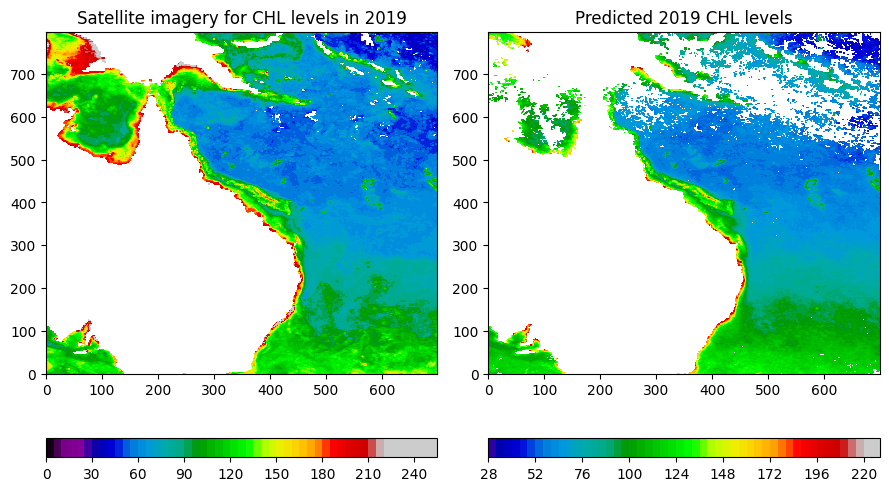

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))


im1 = axes[0].contourf(XG, YG, Y_true, levels=50, cmap="nipy_spectral", vmin=0, vmax=220)
fig.colorbar(im1, ax=axes[0], orientation='horizontal', fraction=0.05)
axes[0].set_title('Satellite imagery for CHL levels in 2019')


im2 = axes[1].contourf(XG, YG, Y_interp, levels=50, cmap="nipy_spectral", vmin=0, vmax=220)
fig.colorbar(im2, ax=axes[1], orientation='horizontal', fraction=0.05)
axes[1].set_title('Predicted 2019 CHL levels')


plt.tight_layout()
plt.show()

# Feed in data from 2021 - 2024

## Load in data

In [15]:
path = 'drive/MyDrive/Fall 2024/CEE609/'

WLA24 = np.load(path+"WLA24.npy")
PAR24 = np.load(path+"PAR24.npy")
PIC24 = np.load(path+"PIC24.npy")
POC24 = np.load(path+"POC24.npy")

## Look at scatterplots

In [16]:
WLA24_v = WLA24[:,0]
PAR24_v = PAR24[:,0]
PIC24_v = PIC24[:,0]
POC24_v = POC24[:,0]

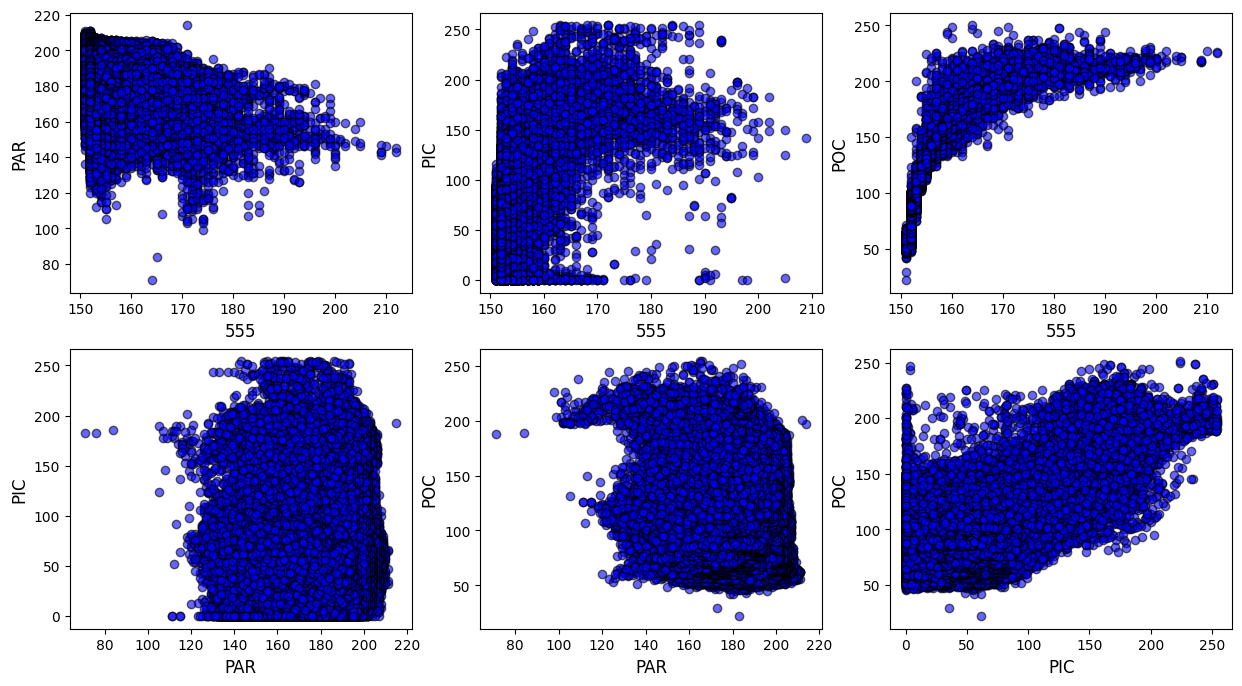

In [17]:
# between predictor variables

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

axes[0, 0].scatter(WLA24_v, PAR24_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 0].set_xlabel("555", fontsize=12);
axes[0, 0].set_ylabel("PAR", fontsize=12);

axes[0, 1].scatter(WLA24_v, PIC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 1].set_xlabel("555", fontsize=12);
axes[0, 1].set_ylabel("PIC", fontsize=12);

axes[0, 2].scatter(WLA24_v, POC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 2].set_xlabel("555", fontsize=12);
axes[0, 2].set_ylabel("POC", fontsize=12);

axes[1, 0].scatter(PAR24_v, PIC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 0].set_xlabel("PAR", fontsize=12);
axes[1, 0].set_ylabel("PIC", fontsize=12);

axes[1, 1].scatter(PAR24_v, POC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 1].set_xlabel("PAR", fontsize=12);
axes[1, 1].set_ylabel("POC", fontsize=12);

axes[1, 2].scatter(PIC24_v, POC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 2].set_xlabel("PIC", fontsize=12);
axes[1, 2].set_ylabel("POC", fontsize=12);


## Prepare data

In [18]:
# remove rows containing NaN
X = np.hstack([WLA24, PAR24, PIC24, POC24])
mask = ~np.isnan(X).any(axis=1)

X   = X[mask]
xgv = XGv[mask]
ygv = YGv[mask]

# ensure there are no NaN values
print("NaN values in X: ", np.isnan(X).any())


print("Shape of X  : ", X.shape)
print("Shape of xgv: ", xgv.shape)
print("Shape of ygv: ", ygv.shape)

NaN values in X:  False
Shape of X  :  (197578, 144)
Shape of xgv:  (197578, 1)
Shape of ygv:  (197578, 1)


## Model prediction

In [19]:
Y = model.predict(X)

## Reinterpolate onto grid and plot

In [20]:
# interpolate onto grid
Y_interp = griddata((xgv.flatten(), ygv.flatten()), Y.flatten(), (XG, YG), method='linear')

# mask out continent
MASK = mask.reshape(GBR_sz[0], GBR_sz[1])
Y_interp[~MASK] = np.nan


## Load in most current sattelite image

In [21]:
url = "https://oceancolor.gsfc.nasa.gov/showimages/MODISA/IMAGES/CHL/L3/2024/1001/AQUA_MODIS.20241001_20241031.L3m.MO.CHL.chlor_a.4km.NRT.nc.png"

image = Image.open(urllib.request.urlopen(url))
image_array = np.array(image)

image_nan = np.where(image_array == 255, np.nan , image_array)
image_masked = np.ma.masked_invalid(image_nan)
image_masked = np.flipud(image_masked)

CHL24  = image_masked[GBR_loc[0,0]:GBR_loc[0,1], GBR_loc[1,0]:GBR_loc[1,1]]

## Plot most recent CHL levels and compare with 2025 prediction

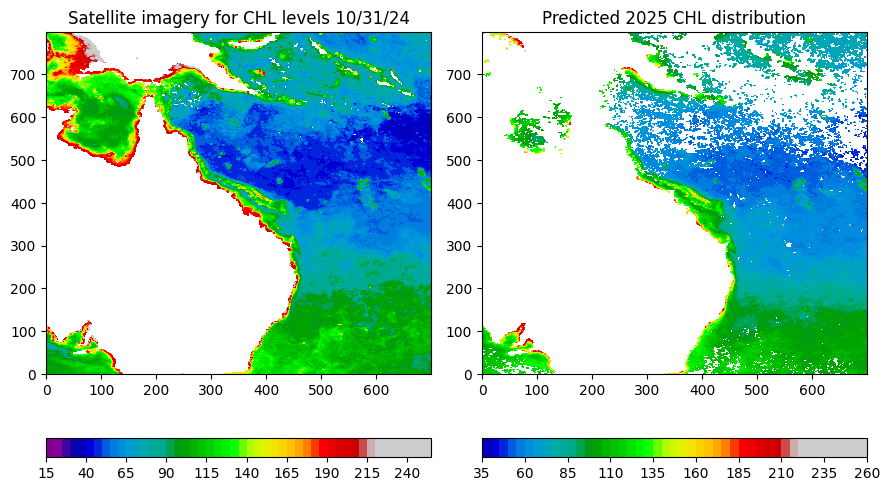

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))


im1 = axes[0].contourf(XG, YG, CHL24, levels=50, cmap="nipy_spectral", vmin=0, vmax=220)
fig.colorbar(im1, ax=axes[0], orientation='horizontal', fraction=0.05)
axes[0].set_title('Satellite imagery for CHL levels 10/31/24')


im2 = axes[1].contourf(XG, YG, Y_interp, levels=50, cmap="nipy_spectral", vmin=0, vmax=220)
fig.colorbar(im2, ax=axes[1], orientation='horizontal', fraction=0.05)
axes[1].set_title('Predicted 2025 CHL distribution')


plt.tight_layout()
plt.show()
